# import

In [1]:
import numpy as np
from scipy import stats #高度な科学技術計算を行うためのモジュール
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 
from IPython.display import display, HTML # 画像表示などを行うためのモジュール
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# メソッドの定義

In [22]:
def log_likelihood(data, center, cov):
            return sum(stats.multivariate_normal.logpdf(x, center, cov) for x in data)

In [29]:
def bic(data, center, cov):
            return -2 * log_likelihood(data, center, cov) + 2 * np.log(data.size)

# Xmeansのクラス

In [41]:
class XMeans:
    """
    x-means法を行うクラス
    """

    def __init__(self, k_init = 2, **k_means_args):
        """
        k_init : The initial number of clusters applied to KMeans()
        """
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        """
        x-means法を使ってデータXをクラスタリングする
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        """
        self.__clusters = [] #clustersにはもうこれ以上分割しないデータが格納される

        clusters = self.Cluster.build(X, KMeans(self.k_init, **self.k_means_args).fit(X))
        self.__recursively_split(clusters)

        self.labels_ = np.empty(X.shape[0], dtype = np.intp)
        for i, c in enumerate(self.__clusters):
            self.labels_[c.index] = i

        self.cluster_centers_ = np.array([c.center for c in self.__clusters])
        self.cluster_log_likelihoods_ = np.array([c.log_likelihood() for c in self.__clusters])
        self.cluster_sizes_ = np.array([c.size for c in self.__clusters])

        return self

    def __recursively_split(self, clusters):
        """
        引数のclustersを再帰的に分割する
        clusters : list-like object, which contains instances of 'XMeans.Cluster'
        'XMeans.Cluster'のインスタンスを含むリスト型オブジェクト
        """
        for cluster in clusters:
            if cluster.size <= 3:
                self.__clusters.append(cluster) #仮説：クラスタに含まれるデータの個数が3個以内の場合はこれ以上分割しない
                continue #cluster.size<=3だったら次のループへいく。そうではなかったら次の処理へ進む

            k_means = KMeans(2, **self.k_means_args).fit(cluster.data)
            c1, c2 = self.Cluster.build(cluster.data, k_means, cluster.index)

            beta = np.linalg.norm(c1.center - c2.center) / np.sqrt(np.linalg.det(c1.cov) + np.linalg.det(c2.cov))
            alpha = 0.5 / stats.norm.cdf(beta)
            bic = -2 * (cluster.size * np.log(alpha) + c1.log_likelihood() + c2.log_likelihood()) + 2 * cluster.df * np.log(cluster.size)
                      
            if bic < cluster.bic():
                self.__recursively_split([c1, c2]) #更なる分割を行う
            else:
                self.__clusters.append(cluster) #これ以上分割しない

    class Cluster:
        """
        k-means法によって生成されたクラスタに関する情報を持ち、尤度やBICの計算を行うクラス
        """

        @classmethod
        def build(cls, X, k_means, index = None): 
            if index is None:
                index = np.array(range(0, X.shape[0]))
            labels = range(0, k_means.get_params()["n_clusters"])  

            return tuple(cls(X, index, k_means, label) for label in labels) #ここでクラスター結果を入れたインスタンスを生成し、クラスタ数分の「インスタンスを返す
        

        # index: Xの各行におけるサンプルが元データの何行目のものかを示すベクトル
        def __init__(self, X, index, k_means, label):
            self.data = X[k_means.labels_ == label]
            self.index = index[k_means.labels_ == label]
            self.size = self.data.shape[0]
            self.df = self.data.shape[1] * (self.data.shape[1] + 3) / 2
            self.center = k_means.cluster_centers_[label]
            self.cov = np.cov(self.data.T)

        def log_likelihood(self):
            return sum(stats.multivariate_normal.logpdf(x, self.center, self.cov) for x in self.data)

        def bic(self):
            return -2 * self.log_likelihood() + self.df * np.log(self.size)

# シミュレーションデータ作成

No handles with labels found to put in legend.


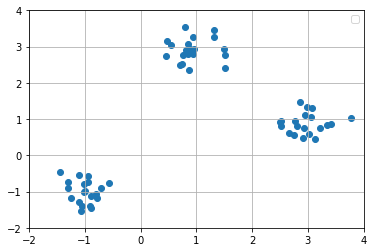

In [74]:
#シミュレーションデータ作成
x = np.array([np.random.normal(loc, 0.3, 20) for loc in [3, 1, -1]]).flatten() #ランダムな80個の数を生成
y = np.array([np.random.normal(loc, 0.3, 20) for loc in [1, 3, -1]]).flatten() #ランダムな80個の数を生成
data = np.c_[x, y]

plt.scatter(x, y)
plt.xlim(-2, 4)
plt.ylim(-2, 4)
plt.legend()
plt.grid()
plt.show()

# kmeansの実行

No handles with labels found to put in legend.


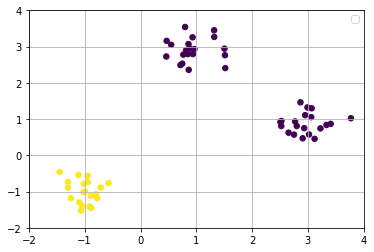

In [80]:
#kmeansを実装
km_model_cos_sim = KMeans(
    n_clusters = 2,
    random_state = 10,
    init = "random"
    )

#モデルへのあてはめ
y_km_cos_sim = km_model_cos_sim.fit(data)

#結果をプロット
plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
plt.scatter(x, y, c = y_km_cos_sim.labels_, s = 30)
plt.xlim(-2, 4)
plt.ylim(-2, 4)
plt.legend()
plt.grid()
plt.show()

# xmeansの実行

No handles with labels found to put in legend.


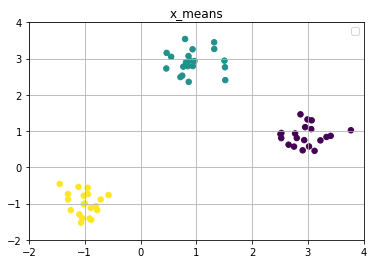

In [77]:
#x-means実行
x_means = XMeans(random_state = 1).fit(data)

#結果をプロット
plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
plt.scatter(x, y, c = x_means.labels_, s = 30)
plt.xlim(-2, 4)
plt.ylim(-2, 4)
plt.title("x_means")
plt.legend()
plt.grid()
plt.show()

In [57]:
x_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# BICの計算

In [81]:
#0回分割
mean_x = np.mean(x)
mean_y = np.mean(y)
data_cov = np.cov(data.T)

#BIC
print(bic(data=data, center=[mean_x, mean_y], cov=data_cov))

453.95056102333285


In [78]:
#1回分割
#クラスタをごとにデータを分ける
x1 = x[0:20]
x2 = x[20:60]
y1 = y[0:20]
y2 = y[20:60]

data1 = np.c_[x1, y1]
data2 = np.c_[x2, y2]

#各クラスタの平均
mean_x1 = np.mean(x1)
mean_y1 = np.mean(y1)
mean_x2 = np.mean(x2)
mean_y2 = np.mean(y2)

#共変量を計算
data1_cov = np.cov(data1.T)
data2_cov = np.cov(data2.T)

In [50]:
#1回分割したクラスタのBIC
print(bic(data=data1, center=[mean_x1, mean_y1], cov=data1_cov))
print(bic(data=data2, center=[mean_x2, mean_y2], cov=data2_cov))

25.1328666145827
189.5000637328615


In [79]:
#2回分割
#クラスタをごとにデータを分ける
x1 = x[0:20]
x2 = x[20:40]
x3 = x[40:60]
y1 = y[0:20]
y2 = y[20:40]
y3 = y[40:60]


data1 = np.c_[x1, y1]
data2 = np.c_[x2, y2]
data3 = np.c_[x3, y3]

#各クラスタの平均
mean_x1 = np.mean(x1)
mean_y1 = np.mean(y1)
mean_x2 = np.mean(x2)
mean_y2 = np.mean(y2)
mean_x3 = np.mean(x3)
mean_y3 = np.mean(y3)

#共変量を計算
data1_cov = np.cov(data1.T)
data2_cov = np.cov(data2.T)
data3_cov = np.cov(data3.T)

In [52]:
#2回分割したクラスタのBIC
print(bic(data=data1, center=[mean_x1, mean_y1], cov=data1_cov))
print(bic(data=data2, center=[mean_x2, mean_y2], cov=data2_cov)+bic(data=data3, center=[mean_x3, mean_y3], cov=data3_cov))

25.1328666145827
48.2848894883386
